# Capstone 2

## Part 4: Modelling

Let's try out some new models! First, let's have a look at a linear regression. We'll sort the coefficients by absolute value to get a sense of the linear contribution of each feature to the quality score:

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd

X_train = pd.read_csv('../data/X_train.csv')
X_test = pd.read_csv('../data/X_test.csv')
y_train = pd.read_csv('../data/y_train.csv').values.ravel()
y_test = pd.read_csv('../data/y_test.csv').values.ravel()
y_train_reclass = pd.read_csv('../data/y_train_reclass.csv').values.ravel()
y_test_reclass = pd.read_csv('../data/y_test_reclass.csv').values.ravel()

## Original and simplified targets
The original target values are distributed in a narrow band between quality values of 5's through 7's with the largest population of 6's. 3's, 4's, 8's and 9's are sparse. Rather than try to classify in a range of 3 to 9, we will simplify the target to three values: less than 6, 6, and more than 6. 

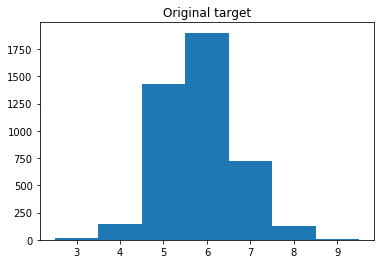

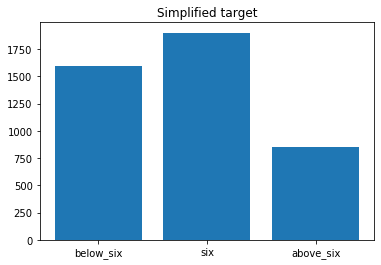

In [3]:
import matplotlib.pyplot as plt
import numpy as np
plt.hist(y_train,bins=[3,4,5,6,7,8,9,10],align='left')
plt.title('Original target')
plt.show()
above_six = np.sum(y_train_reclass == 'above_six')
six = np.sum(y_train_reclass == 'six')
below_six = np.sum(y_train_reclass == 'below_six')
plt.bar(['below_six','six','above_six'],[below_six,six,above_six])
plt.title('Simplified target')
plt.show()

### Logistic regression on original target
The original target has is the subjective rating of wine quality on scale of 0 to 10. The data set includes discrete quality values in a set {3,4,5,6,7,8,9}. Here's an attempt to fit a logistic regression classifier.

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Balanced accuracy: 0.22139220804242252


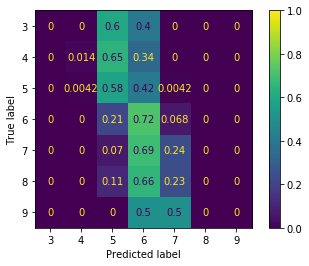

              precision    recall  f1-score   support

           3       0.00      0.00      0.00        10
           4       0.25      0.01      0.03        71
           5       0.59      0.58      0.58       706
           6       0.52      0.72      0.61       936
           7       0.51      0.24      0.33       356
           8       0.00      0.00      0.00        64
           9       0.00      0.00      0.00         2

    accuracy                           0.54      2145
   macro avg       0.27      0.22      0.22      2145
weighted avg       0.52      0.54      0.51      2145



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [4]:
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report

def model_results(model,X_test,y_test):
    y_pred = lr.predict(X_test)
    print('Balanced accuracy:', balanced_accuracy_score(y_test,y_pred))
    plot_confusion_matrix(model,X_test,y_test,normalize='true')
    try:
        for im in plt.gca().get_images():
            im.set_clim(0., 1.)
        plt.clim(0,1)
    except:
        pass
    plt.show()
    print(classification_report(y_test, y_pred))
    
lr = LogisticRegression()
lr.fit(X_train,y_train)
model_results(lr,X_test,y_test)

First, note the convergence warning. This indicates that there was a problem fitting the data. The balanced accuracy is very low at 0.22.

Next, note that the predicted values largely fall within a band from 5-7 with a handful of 4's. No target values of 3's 8's or 9's were predicted. This result indicates that the predictive power of the model follows where the target values are concentrated. 

This initial result supports reclassifying the target values into three classes where this logistic regression model provides predictive power. 

## Logistic regression on the simplified target
The target is now reclassified into three groups: less than six, six, and greater than six. Logistic regression is repeated.

Balanced accuracy: 0.5328658622128635


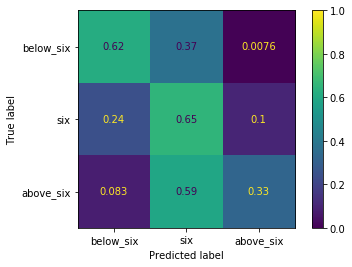

              precision    recall  f1-score   support

   below_six       0.57      0.33      0.42       422
         six       0.65      0.62      0.63       787
   above_six       0.53      0.65      0.58       936

    accuracy                           0.58      2145
   macro avg       0.58      0.53      0.54      2145
weighted avg       0.58      0.58      0.57      2145



In [5]:
def model_results(model,X,y):
    y_pred = model.predict(X)
    print('Balanced accuracy:', balanced_accuracy_score(y,y_pred))
    plot_confusion_matrix(model,X,y,labels=['below_six','six','above_six'],normalize='true')
    try:
        for im in plt.gca().get_images():
            im.set_clim(0., 1.)
        plt.clim(0,1)
    except:
        pass
    plt.show()
    print(classification_report(y_test_reclass,y_pred,target_names=['below_six','six','above_six']))

    
lr_reclass = LogisticRegression()
lr_reclass.fit(X_train,y_train_reclass)
model_results(lr_reclass,X_test,y_test_reclass)

By shifting to a smaller number of classes, the problem becomes tractable for logisitic regression. The convergence warning is now gone. 

The balanced accuracy has vastly improved from 0.22 to 0.58. The worst possible misclassifications (classifying above_six's as below_six and vice versa) are nearly absent. For below_six and six, the strongest values lie on the diagonal. above_six is mispredicted more often than not. 

## Random Forests
Let's look at random forest classifiers. We'll compare the standard (unbalanced) vs. imblearn's balanved versions.

Balanced accuracy: 0.6593947240201238


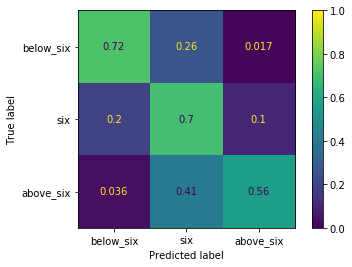

              precision    recall  f1-score   support

   below_six       0.68      0.56      0.61       422
         six       0.74      0.72      0.73       787
   above_six       0.63      0.70      0.67       936

    accuracy                           0.68      2145
   macro avg       0.69      0.66      0.67      2145
weighted avg       0.68      0.68      0.68      2145



In [6]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state = 1, n_jobs=-1)
rfc.fit(X_train,y_train_reclass)

model_results(rfc,X_test,y_test_reclass)

Balanced accuracy: 0.6854092269521912


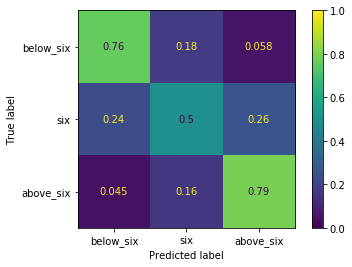

              precision    recall  f1-score   support

   below_six       0.53      0.79      0.64       422
         six       0.72      0.76      0.74       787
   above_six       0.69      0.50      0.58       936

    accuracy                           0.65      2145
   macro avg       0.65      0.69      0.65      2145
weighted avg       0.67      0.65      0.65      2145



In [7]:
from imblearn.ensemble import BalancedRandomForestClassifier

brfc = BalancedRandomForestClassifier(random_state = 1, n_jobs=-1)
brfc.fit(X_train,y_train_reclass)

model_results(brfc,X_test,y_test_reclass)

## Observations
Unbalanced target values have a strong influence on the predictive power of a model. In this case, we observe that target classes that are too sparse are underpredicted by trained models. Results were improved by converting to a simplified target having fewer categories. The classes still remain unbalanced, but the data are no longer as sparse in any category. 

An attempt at classification of the original target using logistic regression resulted in a warning about a convergence error. The warning disappeared when classifying the simplified target using logistic regression. Changing to the simplified target had the effect of significantly improving the balanced accuracy score. 

The remaining class imbalance was treated by using undersampling of bootstrap samples used to construct random forests. Comparing the random forest classifiers of ```sklearn.ensemble.RandomForestClassifier``` with ```imblearn.ensemble.BalancedRandomForestClassifier```,  the balanced accuracy score improves and the confusion matrix becomes more symmetric about the diagnonal. In moving to a balanced forest, there is a penalty of reduced accuracy on the largest class and gains in the less populus classes. 

# Conclusion
The balance of target values has a strong influence on the predictive power of models. For wine quality, the sparsity of data having very low or high quality scores makes it very difficult to train the model to find such values. We shouldn't expect these models to perform very well in identifying these outliers.

To improve the model's predictive power, sparse data can be combined to boost model stability during training. It's important to note the tradeoff: high precision and low accuracy. Simplifying the classes effectively reduces the "resolution" of the model while increasing the balanced accuracy. 

Finally, comparing both the original and simplified targets, it's apparent that there's enough information in the data to avoid gross misclassification (confusing very high and low scores). This can be seen in all confusion matrices as having very low values in the extreme off-diagonal elements. 